In [2]:
# Veri işleme ve analiz için
import pandas as pd
import numpy as np

# Veri ön işleme için
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, roc_auc_score, f1_score

# Sınıf dengesizliği için
from imblearn.over_sampling import SMOTE

# Derin öğrenme için
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping
from keras import optimizers

# Ölçekleme için
from sklearn.preprocessing import StandardScaler

# Uyarıları görmezden gelme
import warnings
warnings.filterwarnings('ignore')


In [3]:
# Verileri yükleyelim
train_data = pd.read_csv('./train.csv')
test_data = pd.read_csv('./test.csv')

# İlk birkaç satırı görelim
print("Eğitim verisi ilk 5 satır:")
print(train_data.head())


Eğitim verisi ilk 5 satır:
      id  value_increased  Ability  Potential Positions Caps / Goals   Foot  \
0  74044            False     46.0        NaN       AMC          NaN  Right   
1  83969            False     48.0        NaN        GK          NaN  Right   
2  94664            False     58.0        NaN     DL DC          NaN   Left   
3  46208             True     38.0        NaN        DC          NaN  Right   
4  77969            False     47.0        NaN        GK          NaN  Right   

   Height Weight  Aerial Reach  ...  Dribbling  Finishing  Free Kick Taking  \
0  178 CM  72 KG           NaN  ...       45.0       35.0              35.0   
1  185 CM  82 KG          55.0  ...        NaN        NaN              35.0   
2  185 CM  80 KG           NaN  ...       40.0       30.0              15.0   
3  185 CM  74 KG           NaN  ...       15.0       10.0              20.0   
4  193 CM  73 KG          35.0  ...        NaN        NaN              40.0   

   Heading  Long Shots 

In [4]:
# 'value_increased' sütununu 1 ve 0 olarak değiştirelim
train_data['value_increased'] = train_data['value_increased'].apply(lambda x: 1 if x == True else 0)

# Değişikliği kontrol edelim
print("\n'value_increased' sütunu:")
print(train_data['value_increased'].value_counts())



'value_increased' sütunu:
value_increased
0    395
1     70
Name: count, dtype: int64


In [5]:
# 'Potential' sütununu silelim
train_data.drop('Potential', axis=1, inplace=True)
test_data.drop('Potential', axis=1, inplace=True)


In [6]:
# Milli takımda oynamışsa 1, oynamamışsa 0 yapalım
train_data['Caps / Goals'] = train_data['Caps / Goals'].apply(lambda x: 1 if not pd.isna(x) else 0)
test_data['Caps / Goals'] = test_data['Caps / Goals'].apply(lambda x: 1 if not pd.isna(x) else 0)


In [7]:
# 'Right' için 1, 'Left' için 0 atayalım
train_data['Foot'] = train_data['Foot'].map({'Right': 1, 'Left': 0})
test_data['Foot'] = test_data['Foot'].map({'Right': 1, 'Left': 0})


In [8]:
# 'Height' sütunundan ' CM' ifadesini kaldırıp sayısala dönüştürelim
train_data['Height'] = train_data['Height'].str.replace(' CM', '').astype(float)
test_data['Height'] = test_data['Height'].str.replace(' CM', '').astype(float)

# 'Weight' sütunundan ' KG' ifadesini kaldırıp sayısala dönüştürelim
train_data['Weight'] = train_data['Weight'].str.replace(' KG', '').astype(float)
test_data['Weight'] = test_data['Weight'].str.replace(' KG', '').astype(float)


In [9]:
# 'Is_GK' sütununu oluşturalım
train_data['Is_GK'] = train_data['Positions'].apply(lambda x: 1 if 'GK' in x.split() else 0)
test_data['Is_GK'] = test_data['Positions'].apply(lambda x: 1 if 'GK' in x.split() else 0)

# Kaleci özellikleri
goalkeeper_attributes = ['Aerial Reach', 'Command of Area', 'Communication', 'Eccentricity',
                         'Handling', 'Kicking', 'One on Ones', 'Punching (Tendency)', 'Reflexes',
                         'Rushing Out (Tendency)', 'Throwing']

# Kaleci olmayanlar için bu özellikleri 0 yapalım
for attr in goalkeeper_attributes:
    train_data.loc[train_data['Is_GK'] == 0, attr] = 0
    test_data.loc[test_data['Is_GK'] == 0, attr] = 0

# Kaleciler için eksik değerleri ortalama ile dolduralım
for attr in goalkeeper_attributes:
    mean_value = train_data.loc[train_data['Is_GK'] == 1, attr].mean()
    train_data.loc[train_data['Is_GK'] == 1, attr] = train_data.loc[train_data['Is_GK'] == 1, attr].fillna(mean_value)
    test_data.loc[test_data['Is_GK'] == 1, attr] = test_data.loc[test_data['Is_GK'] == 1, attr].fillna(mean_value)


In [10]:
# Benzersiz pozisyonları elde edelim
all_positions = pd.concat([train_data['Positions'], test_data['Positions']])
unique_positions = set()
for positions in all_positions.dropna():
    for pos in positions.split():
        unique_positions.add(pos)
unique_positions = sorted(unique_positions)
print("\nBenzersiz Pozisyonlar:", unique_positions)

# Pozisyonları kodlayalım
def encode_positions(data, position_list):
    for pos in position_list:
        data[f'Position_{pos}'] = data['Positions'].apply(lambda x: 1 if pos in x.split() else 0)
    return data

train_data = encode_positions(train_data, unique_positions)
test_data = encode_positions(test_data, unique_positions)

# Orijinal 'Positions' sütununu kaldıralım
train_data.drop('Positions', axis=1, inplace=True)
test_data.drop('Positions', axis=1, inplace=True)



Benzersiz Pozisyonlar: ['AMC', 'AML', 'AMR', 'DC', 'DL', 'DM', 'DR', 'GK', 'MC', 'ML', 'MR', 'ST', 'WBL', 'WBR']


In [11]:
# Yeni pozisyon sütunlarını kontrol edelim
print("\nYeni pozisyon sütunları:")
print(train_data[[f'Position_{pos}' for pos in unique_positions]].head())



Yeni pozisyon sütunları:
   Position_AMC  Position_AML  Position_AMR  Position_DC  Position_DL  \
0             1             0             0            0            0   
1             0             0             0            0            0   
2             0             0             0            1            1   
3             0             0             0            1            0   
4             0             0             0            0            0   

   Position_DM  Position_DR  Position_GK  Position_MC  Position_ML  \
0            0            0            0            0            0   
1            0            0            1            0            0   
2            0            0            0            0            0   
3            0            0            0            0            0   
4            0            0            1            0            0   

   Position_MR  Position_ST  Position_WBL  Position_WBR  
0            0            0             0             0 

In [12]:
# Sayısal sütunları belirleyelim, 'value_increased' sütununu hariç tutalım
numerical_cols = train_data.select_dtypes(include=['float64', 'int64']).columns.tolist()
if 'value_increased' in numerical_cols:
    numerical_cols.remove('value_increased')

# Eksik değerleri sütunun ortalaması ile dolduralım
for col in numerical_cols:
    mean_value = train_data[col].mean()
    train_data[col] = train_data[col].fillna(mean_value)
    if col in test_data.columns:
        test_data[col] = test_data[col].fillna(mean_value)

# Eksik değerlerin kalmadığını kontrol edelim
print("\nEğitim verisinde eksik değer sayısı:", train_data.isnull().sum().sum())
print("Test verisinde eksik değer sayısı:", test_data.isnull().sum().sum())



Eğitim verisinde eksik değer sayısı: 0
Test verisinde eksik değer sayısı: 0


In [24]:
# Hedef değişkenin sınıf dağılımını kontrol edelim
print("\nSınıf dağılımı:")
print(train_data['value_increased'].value_counts())



Sınıf dağılımı:
value_increased
0    395
1     70
Name: count, dtype: int64


In [26]:
# Özellikleri ve hedef değişkeni ayıralım
X = train_data.drop(['id', 'value_increased'], axis=1)
y = train_data['value_increased']

# SMOTE uygulayalım ve sınıf dağılımını eşitleme
smote = SMOTE(random_state=42, sampling_strategy=1.0)  # Azınlık sınıfını çoğunluk sınıfıyla eşitler
X_resampled, y_resampled = smote.fit_resample(X, y)

# Yeni sınıf dağılımını kontrol edelim
from collections import Counter
print("\nYeni sınıf dağılımı:", Counter(y_resampled))



Yeni sınıf dağılımı: Counter({0: 395, 1: 395})


In [29]:
X_train, X_val, y_train, y_val = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)


In [31]:
# Özellikleri ölçekleyelim
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)


In [33]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.optimizers import Adam
from keras.metrics import AUC

# Modeli oluşturalım
model = Sequential()
model.add(Dense(256, input_dim=X_train_scaled.shape[1], activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(32, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Dense(1, activation='sigmoid'))

In [35]:
# Optimizer'ı tanımlayalım
optimizer = Adam(learning_rate=0.001)

# Modeli derleyelim
model.compile(optimizer=optimizer, 
              loss='binary_crossentropy', 
              metrics=['accuracy', AUC(name='auc')])

In [37]:
# Callbacks'i tanımlayalım
early_stopping = EarlyStopping(monitor='val_loss', patience=60, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, min_lr=1e-6, verbose=1)
model_checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True, verbose=1)


In [39]:
# Modeli eğitelim
history = model.fit(
    X_train_scaled, y_train,
    validation_data=(X_val_scaled, y_val),
    epochs=300,
    batch_size=32,
    callbacks=[early_stopping]
)


Epoch 1/300
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5016 - auc: 0.4990 - loss: 0.8458 - val_accuracy: 0.4937 - val_auc: 0.6797 - val_loss: 0.6805
Epoch 2/300
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5659 - auc: 0.5856 - loss: 0.7561 - val_accuracy: 0.6835 - val_auc: 0.7471 - val_loss: 0.6533
Epoch 3/300
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6250 - auc: 0.6946 - loss: 0.6481 - val_accuracy: 0.7025 - val_auc: 0.7612 - val_loss: 0.6284
Epoch 4/300
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6344 - auc: 0.6757 - loss: 0.6927 - val_accuracy: 0.7025 - val_auc: 0.7956 - val_loss: 0.5994
Epoch 5/300
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6397 - auc: 0.7169 - loss: 0.6261 - val_accuracy: 0.7089 - val_auc: 0.7976 - val_loss: 0.5849
Epoch 6/300
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6988 - auc: 0.7665 - loss: 0.5777 - val_accuracy: 0.7215 - val_auc: 0.8054 - val_loss: 0.5657
Epoch 7/300
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/

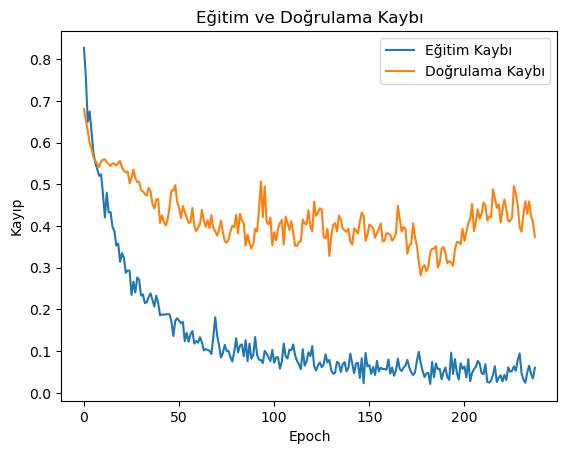

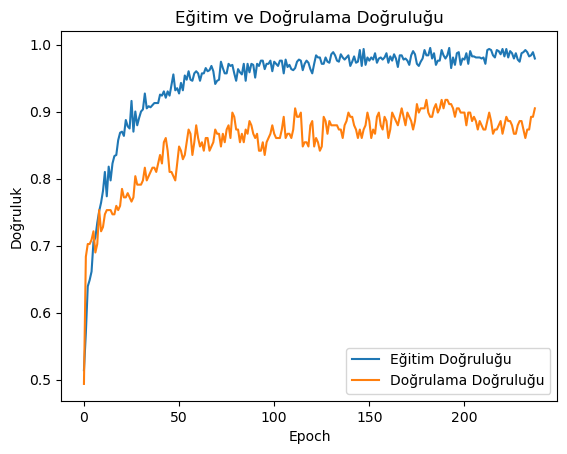

In [41]:
import matplotlib.pyplot as plt

# Eğitim ve doğrulama kayıp değerlerini çizelim
plt.plot(history.history['loss'], label='Eğitim Kaybı')
plt.plot(history.history['val_loss'], label='Doğrulama Kaybı')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Kayıp')
plt.title('Eğitim ve Doğrulama Kaybı')
plt.show()

# Eğitim ve doğrulama doğruluk değerlerini çizelim
plt.plot(history.history['accuracy'], label='Eğitim Doğruluğu')
plt.plot(history.history['val_accuracy'], label='Doğrulama Doğruluğu')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Doğruluk')
plt.title('Eğitim ve Doğrulama Doğruluğu')
plt.show()


In [43]:
# Doğrulama seti üzerinde tahmin yapalım
y_val_pred_probs = model.predict(X_val_scaled)
y_val_pred = (y_val_pred_probs >= 0.5).astype(int).flatten()


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


In [45]:
from sklearn.metrics import classification_report, f1_score

# Sınıflandırma raporu
print("\nDoğrulama seti sınıflandırma raporu:")
print(classification_report(y_val, y_val_pred))

# F1 Skoru
f1 = f1_score(y_val, y_val_pred)
print(f"F1 Skoru: {f1:.4f}")



Doğrulama seti sınıflandırma raporu:
              precision    recall  f1-score   support

           0       0.92      0.88      0.90        75
           1       0.90      0.93      0.91        83

    accuracy                           0.91       158
   macro avg       0.91      0.90      0.90       158
weighted avg       0.91      0.91      0.90       158

F1 Skoru: 0.9112


In [47]:
from sklearn.metrics import roc_auc_score

# ROC AUC Skoru
auc_score = roc_auc_score(y_val, y_val_pred_probs)
print(f"ROC AUC Skoru: {auc_score:.4f}")


ROC AUC Skoru: 0.9749


In [48]:
# Test verisini hazırlayalım
X_test = test_data.drop(['id'], axis=1)

# X_test'in sütunlarını X_train ile hizalayalım
missing_cols_in_test = set(X_train.columns) - set(X_test.columns)
for col in missing_cols_in_test:
    X_test[col] = 0

# Sütun sırasını aynı hale getirelim
X_test = X_test[X_train.columns]

# Test verisini ölçekleyelim
X_test_scaled = scaler.transform(X_test)


In [50]:
# Tahmin yapalım
y_test_pred_probs = model.predict(X_test_scaled)
y_test_pred = (y_test_pred_probs >= 0.5).astype(int).flatten()
y_test_pred_bool = y_test_pred.astype(bool)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step


In [52]:
# Sonuçları hazırlayalım
submission = pd.DataFrame({
    'id': test_data['id'],
    'value_increased': y_test_pred_bool
})

# CSV dosyasına kaydedelim
submission.to_csv('sample_submission.csv', index=False)

print("\nTahminler sample_submission.csv dosyasına kaydedildi.")



Tahminler sample_submission.csv dosyasına kaydedildi.


In [ ]:
#train_data.to_csv('veri.csv', index=True)

In [ ]:
#test_data.to_csv('veritest.csv', index=True)